<a href="https://colab.research.google.com/github/wdwzyyg/Atom-Finder/blob/main/Simu_Datapre%26collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import module

In [ ]:
import scipy
import scipy.fftpack as syfp
from scipy import ndimage as ndi
from scipy import optimize
from skimage.feature import peak_local_max
from skimage.morphology import local_maxima
from pylab import *
from PIL import Image, ImageEnhance
import glob
import os 
import sys
import math
import numpy as np

import matplotlib.pyplot as plt
import scipy.io as scio

import copy
import subprocess
from collections import OrderedDict
import matplotlib.patches as patches
from scipy import fftpack, ndimage, optimize, spatial, stats
from skimage import exposure
from skimage.util import random_noise
from sklearn.feature_extraction.image import extract_patches_2d
#from sklearn.preprocessing import OneHotEncode

import h5py
import tarfile
import cv2

from mpl_toolkits.mplot3d import Axes3D

from scipy.io import loadmat
def map01(mat):
    return (mat - mat.min())/(mat.max() - mat.min())

#### splice large px size image

#### Posprocessing on Prismatic result

In [ ]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def check_finish(datadirc, pos):
    # navigate to the 4D data npy arrays and check simulation state
    f = h5py.File(datadirc, 'r')
    a = f['4DSTEM_simulation']
    b = a['data']
    c = b['datacubes']
    d = c['CBED_array_depth0000']
    e = d['datacube']
    plt.imshow(e[:,:,pos,pos], origin = "lower")

In [ ]:
# navigate to the 4D data npy arrays and show dimention
f = h5py.File('/content/drive/My Drive/Prismatic/WS2-2H/WS2_2H_Attemp2', 'r')
a = f['4DSTEM_simulation']
b = a['data']
c = b['realslices']
print(c.keys())
#d = c['annular_detector_depth0001']
#e = d['realslice']
#plt.imshow(e)

<KeysViewHDF5 ['ppotential']>


In [ ]:
b.keys()

<KeysViewHDF5 ['datacubes', 'diffractionslices', 'pointlistarrays', 'pointlists', 'realslices']>

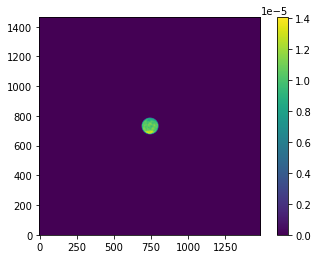

(29, 29, 1464, 1488)

In [ ]:
#show one CBED of new Prismatic
c = b['datacubes']
d = c['CBED_array_depth0001']
e = d['datacube']
plt.imshow(e[2,0], origin = "lower")
plt.colorbar()
plt.show()
e.shape

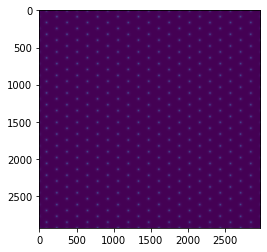

In [ ]:

# check ppotential

g = b['realslices']
potential = g['ppotential']
real = potential['realslice']
real.shape
plt.imshow(real[:,:,3])

#### Read result from Creatphatom

first use the Creatphatom code matlab code to generate px size series

In [ ]:
## Crop truth image
#px = '15'
#path = '/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffMag/px'+px+'pm/WS2_Truth.png
homepath = '/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffMag/px5pm/'
path = homepath+'WS2_Truth.png'
truth  = Image.open(path)
truth = np.asarray(truth)
#small = truth[45:301,45:301] # for 346
small = truth[41:297,41:297] # for 338
#small = truth[42:298,42:298] # for 340
im = Image.fromarray(small, 'L')
im.save(homepath+'WS2_Truth.tif')
os.remove(path)

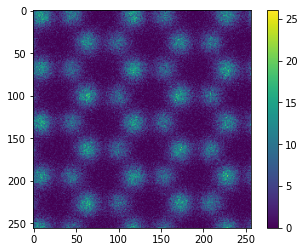

In [ ]:
# Read mat file
from scipy.io import loadmat
#immat = loadmat('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffMag/px'+px+'pm/WS2_000.mat')
immat = loadmat(homepath+'WS2_000.mat')
framenoise = immat['frame_noise']
#framenoise = immat['WS2']
plt.imshow(framenoise)
plt.colorbar()

Contrast: 0.5909090909090909 max 26


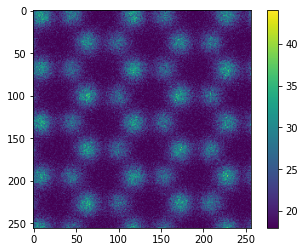

In [ ]:
# change contrast by add background 
# try to control the contrast at constant value: 0.6
factor = 18
background = factor*np.ones((256, 256))
new = np.clip(background+framenoise, a_min = 0, a_max = framenoise.max()+factor)
contrast = (new.max()-new.min())/new.max()
plt.imshow(new)
plt.colorbar()
print("Contrast:",contrast,'max',framenoise.max())  

In [ ]:
new = np.array(new, dtype='float64')
#np.save('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffMag/px'+px+'pm/px'+px+'pm.npy',new)
np.save(homepath+'px5pm.npy',new)
new = (map01(new) * 255).astype('uint8')
im = Image.fromarray(new, 'L')
#im.save('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffMag/px'+px+'pm/px'+px+'pm.tif')
im.save(homepath+'px5pm.tif')

In [ ]:
### a LOOP 

homepath = '/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffFlyback/'
for folder in os.listdir(homepath):
  immat = loadmat(homepath+folder+'/WS2_000.mat')
  framenoise = immat['frame_noise']
  factor = 15
  background = factor*np.ones((256, 256))
  new = np.clip(background+framenoise, a_min = 0, a_max = framenoise.max()+factor)
  contrast = (new.max()-new.min())/new.max()
  print("Contrast:",contrast,'max',framenoise.max())

  new = np.array(new, dtype='float64')

  np.save(homepath+folder +'/'+folder+'.npy',new)
  new = (map01(new) * 255).astype('uint8')
  im = Image.fromarray(new, 'L')
  im.save(homepath+folder +'/'+folder+'.tif')

#### Find ground truth

First find all the atom peaks as ground truth

then limit the threshold to find only the atoms that you want to calculate precision from, called UnaryPeaks_x/y

(256, 256)
Coordinate:  (49, 2)
Coordinate now:  (32, 2)


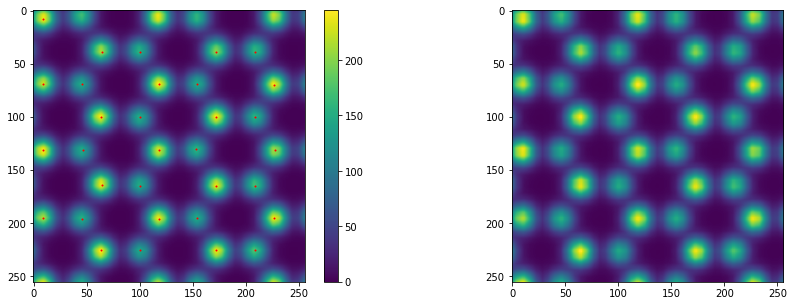

In [ ]:
#path = '/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffMag/px'+px+'pm/px'+px+'pm_Truth.tif'
path = homepath+'WS2_Truth.tif'
#os.chdir(path)
im = Image.open(path)
im = np.asarray(im)
print(im.shape)

#immat = loadmat('/content/drive/MyDrive/AtomfinderProject/Data/DiffContrast/simulate/direct/px22d7pm_000.mat')
#im = immat['frame_noise']
#im = np.asarray(im)
image_max = ndi.maximum_filter(im, size =2, mode = 'constant')
imgaussian = ndi.gaussian_filter(im, sigma = 1)


coordinates = peak_local_max(imgaussian, min_distance = 8, threshold_abs = 0) 
print('Coordinate: ',coordinates.shape)


# the peak_local_max give multiple coordinates with same intensity at flat peak, so try to get rid of them here
co_tempt = coordinates
del_index = []
for i in range(coordinates.shape[0]):
  for j in range(i+1, coordinates.shape[0]):
    dis = math.sqrt((coordinates[i][0]- coordinates[j][0])**2 + (coordinates[i][1] - coordinates[j][1])**2)
###
    if (dis < 2) & (dis > 0):
      del_index.append(j)
coordinates = np.delete(coordinates,del_index,0)
print('Coordinate now: ', coordinates.shape)

fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)
plt.imshow(imgaussian)
plt.colorbar()
plt.scatter(np.transpose(coordinates)[1],np.transpose(coordinates)[0],s = 1, c = 'r')

fig.add_subplot(122)
plt.imshow(image_max)

(28,) float64


"plt.scatter(np.transpose(coordinates)[1],np.transpose(coordinates)[0],s = 1, c = 'r')"

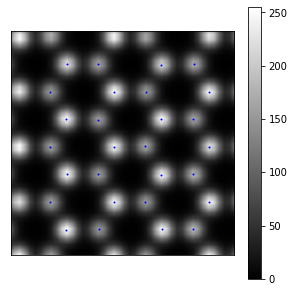

In [ ]:
'''## Get rid of coords in blank area 
del_index = []
for i in range(coordinates.shape[0]):
  if coordinates[i][1]>240:
    del_index.append(i)
coordinates = np.delete(coordinates,del_index,0)
print('Coordinate now: ', coordinates.shape)'''
peak_y_fit, peak_x_fit, edgey, edgex = peakfit(coordinates, im, path,11)
print(peak_y_fit.shape,peak_y_fit.dtype)
'''plt.scatter(np.transpose(coordinates)[1],np.transpose(coordinates)[0],s = 1, c = 'r')'''

(336,) (336,)


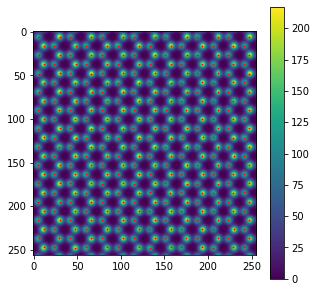

In [ ]:
# Don't use this now. Already tried to delete detected atoms at edge from the models
# combine the unfitted edge points and fitted points

peak_y_fit = np.hstack((peak_y_fit, edgey))
peak_x_fit = np.hstack((peak_x_fit, edgex))
print(peak_y_fit.shape, peak_x_fit.shape)
fig = plt.figure(figsize=(5,5))
plt.imshow(imgaussian)
plt.colorbar()
plt.scatter(peak_x_fit, peak_y_fit, s = 1, c = 'r')

In [ ]:
#savepath = '/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffMag/px'+px+'pm/'
#savepath = '/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffRandomdrift/0/'
np.save(homepath+'Peaks_x.npy', np.asarray(peak_x_fit))
np.save(homepath+'Peaks_y.npy', np.asarray(peak_y_fit))

In [ ]:
savepath = '/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffContrast/'

x = np.load('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/raw_px15pm/Peaks_x.npy')
y = np.load('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/raw_px15pm/Peaks_y.npy')
for folder in os.listdir(savepath):
  try:
    np.save(savepath+folder+'/Peaks_x.npy', np.asarray(x))
    np.save(savepath+folder+'/Peaks_y.npy', np.asarray(y))
  except:
    continue

In [ ]:
for folder in os.listdir('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffFlyback/'):
  try:
    os.remove('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffFlyback/'+folder+'/WS2_Truth.tif')
  except:
    continue

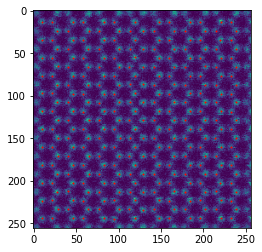

In [ ]:
# Check if the ground truth is correct
#px = '10'
peakx = np.load('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffMag/px'+px+'pm/'+'Peaks_x.npy')
peaky = np.load('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffMag/px'+px+'pm/'+'Peaks_y.npy')
a = np.load('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffMag/px'+px+'pm/px'+px+'pm.npy')
plt.imshow(a)
plt.scatter(peakx, peaky,s =1, c = 'r')

#### Simulated image augmentation

##### contrast

Contrast: 0.4117647058823529 max 255


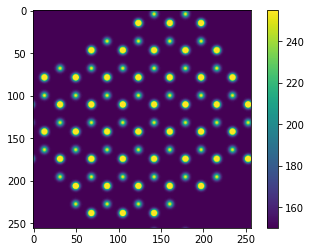

In [ ]:
#Contrast edge test

'''immat = loadmat('/content/drive/My Drive/AtomfinderProject/Data/DiffMag/simulate/px22d7pm/px22d7pm_000.mat')
framenoise = immat['frame_noise']'''
im = Image.open('/content/drive/My Drive/AtomfinderProject/Data/WS2/Simu/origin8d59pm.tif')
framenoise = np.asarray(im)
# change contrast by add background 
factor = 150
background = factor*np.ones((256, 256))
new = np.clip(background+framenoise, a_min = 0, a_max = framenoise.max())
contrast = (new.max()-new.min())/new.max()
plt.imshow(new)
plt.colorbar()
print("Contrast:",contrast,'max',framenoise.max())  

Contrast: 0.01
Contrast: 0.107
Contrast: 0.194
Contrast: 0.272
Contrast: 0.343
Contrast: 0.407
Contrast: 0.465
Contrast: 0.517


array([[ 68, 111,  79, ...,  35,  57,  23],
       [ 90,  90,  90, ..., 111,  46, 111],
       [ 68, 141,  46, ...,  90,  46, 100],
       ...,
       [ 90,  79,  68, ...,  57,  68, 100],
       [131,  57, 141, ...,  90,  46, 141],
       [ 90,  57,  57, ...,  46, 100, 111]], dtype=uint8)

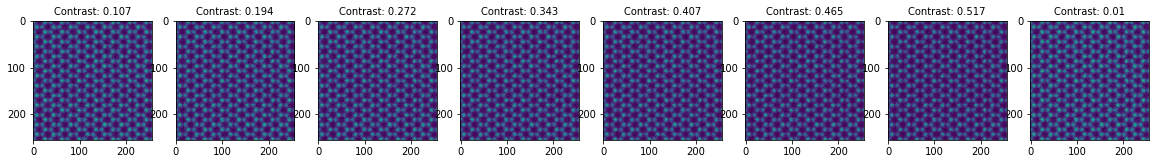

In [ ]:
px = '15'
px_size = 15
immat = loadmat('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/raw_px15pm/WS2_000.mat')
framenoise = immat['frame_noise'].astype('float32')

# Otherwise use 8bit image as input
im = Image.open('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/raw_px15pm/px15pm.tif')
imgdata = np.asarray(im)
a = imgdata

applycontrastgamma(np.clip(framenoise+14,1,1000),0.01,0.8,0.1)


In [ ]:
framenoise.astype('float32')

array([[ 3.,  8.,  4., ...,  0.,  4.,  1.],
       [ 3.,  2.,  5., ...,  4.,  5.,  3.],
       [ 6.,  8.,  9., ...,  4.,  8.,  3.],
       ...,
       [ 1.,  3., 10., ...,  5.,  2.,  2.],
       [ 6.,  7.,  6., ...,  6.,  8.,  3.],
       [ 8.,  6.,  6., ...,  4.,  4.,  2.]], dtype=float32)

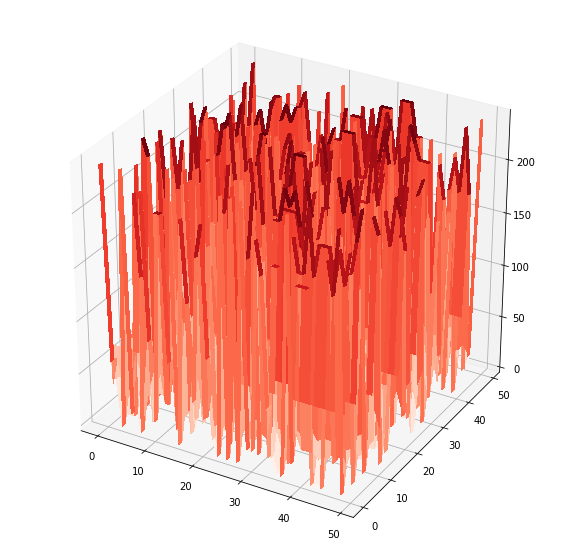

In [ ]:
# check effect of contrast adjustment

a = Image.open('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffContrast/0d412/0d412.tif')
adata = np.asarray(a)
X = range(256)
Y = range(256)
Z = np.asarray(a)
X = np.arange(0, 50, 1)
Y = np.arange(0, 50,1)
X, Y = np.meshgrid(X, Y)

Z = adata[X,Y]
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, linewidth=0, cmap = 'Reds',antialiased=False)

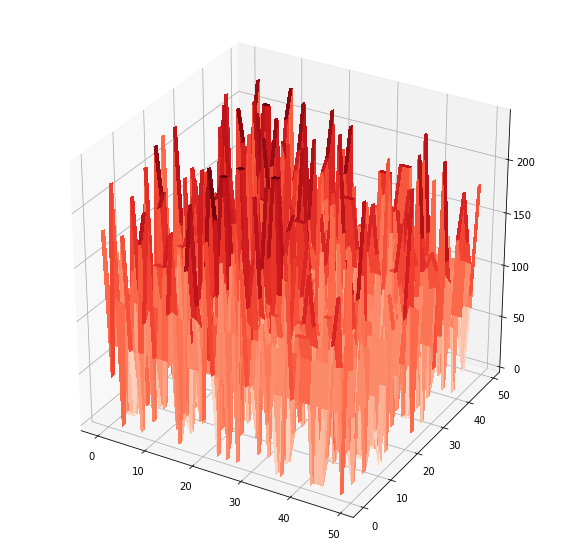

In [ ]:
# check effect of contrast adjustment

a = Image.open('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffContrast/0d059/0d059.tif')
adata = np.asarray(a)
X = range(256)
Y = range(256)
Z = np.asarray(a)
X = np.arange(0, 50, 1)
Y = np.arange(0, 50,1)
X, Y = np.meshgrid(X, Y)

Z = adata[X,Y]
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, linewidth=0, cmap = 'Reds',antialiased=False)

##### Resolution

Souce size: 272.0 pm
Souce size: 281.6 pm
Souce size: 291.2 pm
Souce size: 300.8 pm


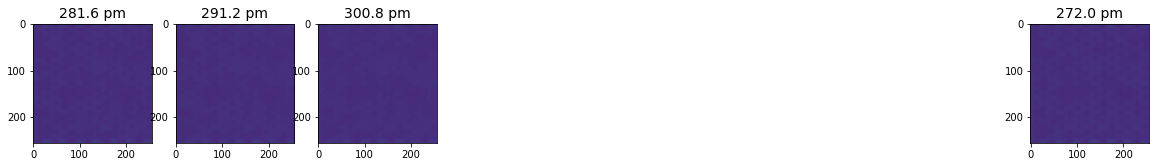

In [ ]:
# pixel size used in both simulation and experiment
px_size = 15
immat = loadmat('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/raw_px15pm/WS2_000.mat')

#framenoise = immat['frame_noise']
HAADF = immat['frame_noise']
applyblur(HAADF, 260, 300, 10, px_size,80)

In [ ]:
x = np.load('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/raw_px15pm/Peaks_x.npy')
y = np.load('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/raw_px15pm/Peaks_y.npy')

savepath = '/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffRandomdrift/'
for folder in os.listdir(savepath):
  try:
    np.save(savepath+folder+'/Peaks_x.npy', np.asarray(x))
    np.save(savepath+folder+'/Peaks_y.npy', np.asarray(y))
  except:
    continue

##### Poisson

PSNR: 27.58 dB
PSNR: 22.69 dB
PSNR: 18.75 dB
PSNR: 15.38 dB
PSNR: 12.57 dB
PSNR: 10.0 dB
PSNR: 7.76 dB
PSNR: 5.71 dB
PSNR: 3.82 dB
PSNR: 2.04 dB


IndexError: ignored

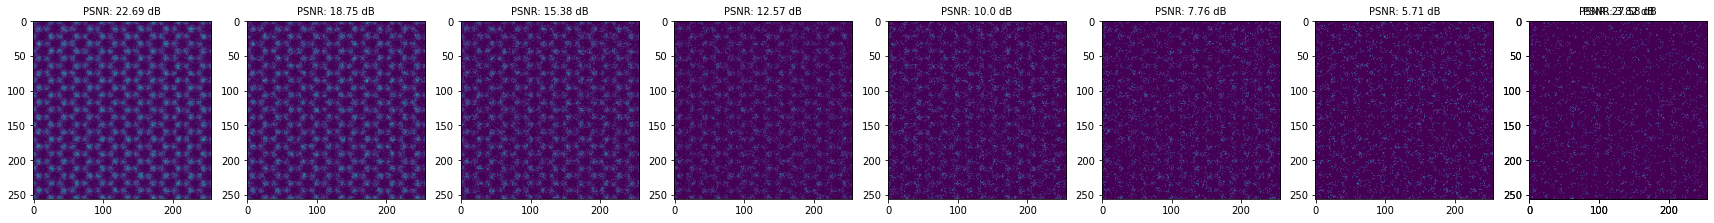

In [ ]:
immat= loadmat('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/raw_px15pm/WS2_000.mat')
source = immat['frame_noise']
applypoisson(source,40,150,10)

####Write csc metadata


In [ ]:
#Write medatada
import csv  
spath = '/content/drive/My Drive/AtomfinderProject/Data/WS2/Exp/DiffMag/15d47pm/'    
# field names  
fields = ['Material',	'Structure type',	'Space group' ,	
          'Zone axis',	'Dimension',	'Pixel size(pm) /Mag',
          'Contrast',	'Resolution(pm)',	'Dwel time(us)',	'Quality',	'Source','Precison(x/pm,y/pm)']  
    
# data rows of csv file  
'''rows = [ 'SrTiO3',  
        'Bulk' ,  
         'Pm3m [221]',  
         '100',  
         '1024 * 1024' ,
         '10.96' ,
         '0.595',
         '95.9',
         '6',
         'Good',
         'Jingrui exp','( 4.74 , 6.89 )']  
'''
rows = [ 'WS2',  
        'SL' ,  
         'P3m1 [164]',  
         '100',  
         '256 * 256' ,
         '15d47' ,
         '0.60',
         '95.4',
         '-',
         'Good',
         'Chenyu exp','-']          

    
# name of csv file  
filename = spath+"metadata.csv"
    
# writing to csv file  
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)  
        
    # writing the fields  
    csvwriter.writerow(fields)  
        
    # writing the data rows  
    csvwriter.writerow(rows)

#### Pack into hdf5

In [ ]:
## load data of a single image for example

rawimdata = loadmat('/content/drive/My Drive/AtomfinderProject/Data/DiffMag/simulate/px23d5pm/px23d5pm_000.mat')['frame_noise']
tif = np.asarray(Image.open('/content/drive/My Drive/AtomfinderProject/Data/DiffMag/simulate/px23d5pm/px23d5pm.tif'))
coordsx = np.load('/content/drive/My Drive/AtomfinderProject/Data/DiffMag/simulate/px23d5pm/Peaks_x.npy')
coordsy = np.load('/content/drive/My Drive/AtomfinderProject/Data/DiffMag/simulate/px23d5pm/Peaks_y.npy')
coords = np.vstack((coordsx,coordsy))

# Write a hdf5 file with hierarchical layers
f = h5py.File('dataset.hdf5', 'w')
STO = f.create_group("STO")
WS2H = f.create_group("WS2H")

Simu = STO.create_group("Simu")
Exp = STO.create_group("Exp")

pxsize = Simu.create_group("pxsize")
size01 = pxsize.create_group("size01")

rawim = size01.create_dataset('raw_img', data = rawimdata)
bit8im = size01.create_dataset('8bit_img', data = tif)
coordsxy = size01.create_dataset('CoordsXY', data = coords)

size01.attrs.create('pxsize',data = 25)
size01.attrs.create('contrast',data = 0.6)

NameError: ignored

In [ ]:
check = h5py.File('dataset.hdf5', 'r+')
descend_obj(check,sep='\t')
#os.remove('/content/dataset.hdf5')

	 - STO : <HDF5 group "/STO" (2 members)>
		 - Exp : <HDF5 group "/STO/Exp" (0 members)>
		 - Simu : <HDF5 group "/STO/Simu" (1 members)>
			 - pxsize : <HDF5 group "/STO/Simu/pxsize" (1 members)>
				 - size01 : <HDF5 group "/STO/Simu/pxsize/size01" (3 members)>
					 - 8bit_img : <HDF5 dataset "8bit_img": shape (256, 256), type "|u1">
					 - CoordsXY : <HDF5 dataset "CoordsXY": shape (2, 450), type "<f8">
					 - raw_img : <HDF5 dataset "raw_img": shape (256, 256), type "<f8">
	 - WS2H : <HDF5 group "/WS2H" (0 members)>


In [ ]:
def descend_obj(obj,sep='\t'):
    """
    Iterate through groups in a HDF5 file and prints the groups and datasets names and datasets attributes
    """
    if type(obj) in [h5py._hl.group.Group,h5py._hl.files.File]:
        for key in obj.keys():
            print (sep,'-',key,':',obj[key])
            descend_obj(obj[key],sep=sep+'\t')
    elif type(obj)==h5py._hl.dataset.Dataset:
        for key in obj.attrs.keys():
            print (sep+'\t','-',key,':',obj.attrs[key])

### Aux functions

In [ ]:
# functions for generating contrast, poisson noise, resolution series

def applycontrast(ori, min, max, step):
        '''
        Change contrast via add background without clip
        '''
        fig = plt.figure(figsize=(20,30))
        h, w = ori.shape[0:2]
        i = -1
        for factor in np.arange(min,max,step):
          background = factor*np.ones((h, w))
          new = ori-background
          new = np.clip(ori+background, a_min = 0, a_max = ori.max()+factor)
          
          #contrast = (new.max()-new.min())/new.max()
          contrast = (new.max()-new.min())/new.mean()
          contrast = round(contrast,3)
          letters = '0d'+ str(contrast)[-3:]
          new = (map01(new) * 255).astype('uint8')
          im = Image.fromarray(new, 'L')
          path = '/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffContrast/'+ letters +'/'
          '''
          if not os.path.isdir(path):
            os.mkdir('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffContrast/'+ letters +'/')
          im.save(path + letters + '.tif')'''
          print("Contrast:",contrast,'factor', factor)
          i = i+1
          
          ax = fig.add_subplot('18{}'.format(i))
          img = ax.imshow(new)
          ax.set_title('Contrast: '+ str(contrast), fontsize=10)
        return new

def applycontrastgamma(ori, min, max, step):
        fig = plt.figure(figsize=(20,30))
        h, w = ori.shape[0:2]
        i = -1
        for factor in np.arange(min,max,step):
          new= exposure.adjust_gamma(ori, factor)
          contrast = (new.max()-new.min())/new.max()
          contrast = round(contrast,3)
          letters = '0d'+ str(contrast)[-3:]
          new = (map01(new) * 255).astype('uint8')
          im = Image.fromarray(new, 'L')
          path = '/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffContrast/'+ letters +'/'
          '''
          if not os.path.isdir(path):
            os.mkdir('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffContrast/'+ letters +'/')
          im.save(path + letters + '.tif')'''
          print("Contrast:",contrast)
          i = i+1
          
          ax = fig.add_subplot('18{}'.format(i))
          img = ax.imshow(new)
          ax.set_title('Contrast: '+ str(contrast), fontsize=10)
        return new


# generate Poission noise series

def applypoisson(ori, min, max, step):
    ''' min >= 5, max <= 67'''
    # Add noise after rescale dataset to number of electrons
    def make_pnoise(image, l):
      vals = len(np.unique(image))
      vals = (50/l) ** np.ceil(np.log2(vals))
      image_n_filt = np.random.poisson(image * vals) / float(vals)
      return image_n_filt

    def psnr(truth, image):
      mse = np.mean( (truth - image) ** 2 )
      PIXEL_MAX = np.amax(truth)
      return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

    i = -1
    fig = plt.figure(figsize=(30,20))
    for factor in np.arange(min,max,step):
      img_noisy = make_pnoise(ori, factor)
      PSNR = psnr(ori, img_noisy)
      PSNR = round(PSNR, 2)
      print("PSNR:",PSNR,'dB')
      new = (map01(img_noisy) * 255).astype('uint8')
      im = Image.fromarray(new, 'L')
      letters = str(PSNR)
      [fron,back] = letters.split(".")
      letters = fron+'d'+ back
      path = '/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffPoisson/'+ letters +'/'
      if not os.path.isdir(path):
        os.mkdir(path)
        im.save(path + letters + '.tif')
      
      i = i+1
      ax = fig.add_subplot('18{}'.format(i))
      ax.imshow(new)
      ax.set_title('PSNR: {} dB'.format(PSNR), fontsize=10)

def applyblur(ori, min, max, step, px_size, ori_radius):
  # pxsize in pm

  def gaussKernel(sigma,imsize):
    x,y = np.meshgrid(range(1,imsize[1]+1),range(1,imsize[0]+1))
    x = x - imsize[1]//2
    y = y - imsize[0]//2
    tmp = -(x**2+y**2)/(2*sigma**2)
    return (1/(2*np.pi*sigma**2))*np.exp(tmp)

  def make_pnoise(image, l):
    vals = len(np.unique(image))
    vals = (50/l) ** np.ceil(np.log2(vals))
    image_n_filt = np.random.poisson(image * vals) / float(vals)
    return image_n_filt

  int_max = np.amax(ori)
  int_min = np.amin(ori)
  fig = plt.figure(figsize=(20,30))
  i = -1

  for size in np.arange(min,max,step):
    sigma = (size/px_size)/(2.355)
    kernel = gaussKernel(sigma,ori.shape)
    fkernel = np.fft.fft2(kernel)
    sim_ss = np.fft.fftshift(np.fft.ifft2(fkernel*np.fft.fft2(ori))).real
    finalsize = np.round(math.sqrt(ori_radius**2 + size**2),1)  ########
    print("Souce size:",finalsize,'pm')

    # add some poisson noise to make the filtered image more realistic
    sim_noise = make_pnoise(sim_ss, 30)
    new = (map01(sim_noise) * 255).astype('uint8')
    im = Image.fromarray(new, 'L')
    letters = str(finalsize)+'pm'
    os.mkdir('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffResolution/'+ letters +'/')
    im.save('/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffResolution/'+ letters +'/'+ letters + '.tif')

    i = i+1
    ax = fig.add_subplot('18{}'.format(i))
    ax.imshow(sim_ss,clim = [int_min, int_max])
    ax.set_title(str(finalsize) + ' pm', fontsize=14)


In [ ]:
def peakfit(coordinates, im, path,size):
  # the accuracy of this output is dtpye64float
  peak_x_fit = []
  peak_y_fit = []
  egde_x = []
  egde_y = []
  for i in range(coordinates.shape[0]):

    x = int(coordinates[i][1])
    y = int(coordinates[i][0])
    if (y < size) or (y > (im.shape[0]-1-size)) or (x < size) or (x > (im.shape[0]-1-size)):
      egde_x.append(coordinates[i][1])
      egde_y.append(coordinates[i][0])
      continue

    patch = im[y-size:y+size, x-size:x+size]
    bg = np.amin(patch)  # minimum value within im
    guess = (bg, patch[size,size]-bg, size, size, (size-1)/2, (size-1)/2)
    bounds = ([min(0,bg), 0, 0, 0, 1, 1], [np.inf, np.inf, size*2, size*2, size*2-2, size*2-2])
#    print('bounds', bounds) 
#    print('guess', guess)
    param = fitGaussianx2(patch, guess, bounds)

    peak_x_fit.append(param[2]+x-size)
    peak_y_fit.append(param[3]+y-size)

  fig = plt.figure(figsize = (5,5))
  im0 = plt.imshow(im, cmap = plt.cm.gray)
  fig = colorbar(im0)
  plt.scatter(peak_x_fit, peak_y_fit,s = 1, c = 'b')


  plt.xticks([]) 
  plt.yticks([])

  peak_x_fit = np.asarray(peak_x_fit)
#  np.save(path+'Peaks_x.npy', np.asarray(peak_x_fit))
  peak_y_fit = np.asarray(peak_y_fit)
#  np.save(path+'Peaks_y.npy', np.asarray(peak_y_fit))  
  return peak_y_fit, peak_x_fit, egde_y, egde_x

def gaussianx2(xdata_tuple, bg, height, center_x, center_y, width_x, width_y):

    (x, y) = xdata_tuple
    width_x = float(width_x)
    width_y = float(width_y)
    g = height*exp(
                 -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)+bg
    return g.ravel() 

def fitGaussianx2(data, guess, bounds):
    x = np.linspace(0, data.shape[1]-1, data.shape[1])
    y = np.linspace(0, data.shape[0]-1, data.shape[0])
    x, y = np.meshgrid(x, y)
    xdata_tuple = (x,y)
    ## Parameter here
    popt, pcov = optimize.curve_fit(gaussianx2, xdata_tuple, data.ravel(), p0=guess,bounds=bounds,verbose=0,maxfev=100000)
    return popt

In [ ]:
#calculate precision from coordinate

def FindPrecision(peaks_x,peaks_y,intensity,threshold,separation,est_spacing):
  '''
# Only effective if the Sr/Ti peak intensity is distinguishable 
# Refered to https://github.com/CY-Zhang/PyProcessingCodes/blob/master/JDDC/DoseTest_exp.ipynb
# Threshold: only atoms intensity above the threshold will be counted
# Separation: set to be half the atom radius in px, define range of points to calculate std deviation
# The remain atom grid should be tetragons. 
  '''
  peaks_int = []
  for i in range(len(peaks_x)):
    c= (int(peaks_y[i]),int(peaks_x[i]))
    peaks_int.append(float(intensity[c]))

  array_x = np.asarray(peaks_x)
  array_y = np.asarray(peaks_y)
  array_int = np.asarray(peaks_int)
  print('array_x',len(array_x),'array_y',len(array_y), 'array_int',len(array_int))
#
  index = np.where((array_x>50) & (array_x<1000) & (array_y > 50) & (array_y < 1000) & (array_int>0))
  array_x = array_x[index]
  array_y = array_y[index]
  array_int = array_int[index]
  print('After cut edge: array_x',len(array_x),'array_y',len(array_y), 'array_int',len(array_int))

  hist_bin = np.arange(np.amin(array_int),np.amax(array_int),2) #start,stop,step
  fig = plt.subplots(figsize=(6,2))
  plt.hist(array_int, bins=hist_bin)
  plt.title('Peak Intensity Histogram')

#     hist, bin_edges = np.histogram(array_int,bins=np.arange(np.amin(array_int)+0.5,np.amax(array_int),0.2), density=True)
#     threshold = bin_edges[argmin(hist)]
#  threshold = np.sort(array_int)[-5]
  print('Threshold',threshold)
  lattice1 = np.where(array_int>threshold)
  array_x1 = array_x[lattice1]
  array_y1 = array_y[lattice1]
  array_int1 = array_int[lattice1]
  print('After threshold: array_x',len(array_x1),'array_y',len(array_y1), 'array_int',len(array_int1))  
  fig = plt.subplots(figsize=(5,5))
  plt.scatter(array_x1,array_y1,s = 1)

  return FindXStd(array_x1,array_y1,separation,est_spacing), FindYStd(array_x1,array_y1,separation,est_spacing)

def FindYStd(array_x1_copy,array_y1_copy,separation,est_spacing):
    y_sep = []
    while array_x1_copy.size != 0:
        x_cor = array_x1_copy[0]
        index = np.where((array_x1_copy<x_cor+separation) & (array_x1_copy>x_cor-separation))
        array_y_sub = array_y1_copy[index]
        array_y_sub = np.sort(array_y_sub)
        for i in range(array_y_sub.shape[0]-1):
            spacing = array_y_sub[i+1] - array_y_sub[i]
            if (spacing < est_spacing + separation) & (spacing > est_spacing - separation):
                y_sep.append(spacing)
        array_x1_copy = np.delete(array_x1_copy,index)
        array_y1_copy = np.delete(array_y1_copy,index)
    print('Total counted y spacing number: ',len(y_sep))
    y_std = np.std(np.asarray(y_sep))
#     fig = plt.subplots(figsize=(6,2))
#     plt.hist(y_sep, bins='auto')
#     plt.title('Hist along y, std= '+str(y_std))
    return y_std


def FindXStd(array_x1_copy,array_y1_copy,separation,est_spacing):
    x_sep = []
    while array_x1_copy.size != 0:
        y_cor = array_y1_copy[0]
        index = np.where((array_y1_copy<y_cor+separation) & (array_y1_copy>y_cor-separation))
        array_x_sub = array_x1_copy[index]
        array_x_sub = np.sort(array_x_sub)
        for i in range(array_x_sub.shape[0]-1):
            spacing = array_x_sub[i+1] - array_x_sub[i]
            if (spacing < est_spacing + separation) & (spacing > est_spacing - separation):
                x_sep.append(array_x_sub[i+1] - array_x_sub[i])
        array_x1_copy = np.delete(array_x1_copy,index)
        array_y1_copy = np.delete(array_y1_copy,index)
    print('Total counted x spacing number: ',len(x_sep))
    x_std = np.std(np.asarray(x_sep))
#     fig = plt.subplots(figsize=(6,2))
#     plt.hist(x_sep, bins='auto')
#     plt.title('Hist along x, std= '+str(x_std))
    return x_std

In [ ]:
def rename_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            if name[-3:] =='png':
              new = root[-9:]
              os.rename(os.path.join(root,name),os.path.join(root,new[:9]+'.png'))

#rename_files('/content/drive/My Drive/AtomfinderProject/Data/Diffdistortion/flybackerror/')